In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from PCA_NP import pca_np

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
#read all images from the folder
def read_images(folder_images, folder_masks):
    dict_images = {}
    for filename in os.listdir(folder_images):
        img = Image.open(os.path.join(folder_images, filename))
        mask = Image.open(os.path.join(folder_masks, filename.split('.')[0] + '_segmentation.png'))
        if img is not None and mask is not None:
            dict_images[filename.split('.')[0]] = {}
            dict_images[filename.split('.')[0]]['image'] = img
            dict_images[filename.split('.')[0]]['mask'] = mask
            matrices, explained_var_scores = pca_np(np.array(img))
            dict_images[filename.split('.')[0]]['pca'] = (matrices, explained_var_scores)
    return dict_images

In [6]:
folder_images = '../../data/kvasir_new_processed/train/images'
folder_masks = '../../data/kvasir_new_processed/train/masks'

In [7]:
images_dict = read_images(folder_images, folder_masks)

In [36]:
#DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem[1]['pca'][1])
#    if i == 0:
#        break

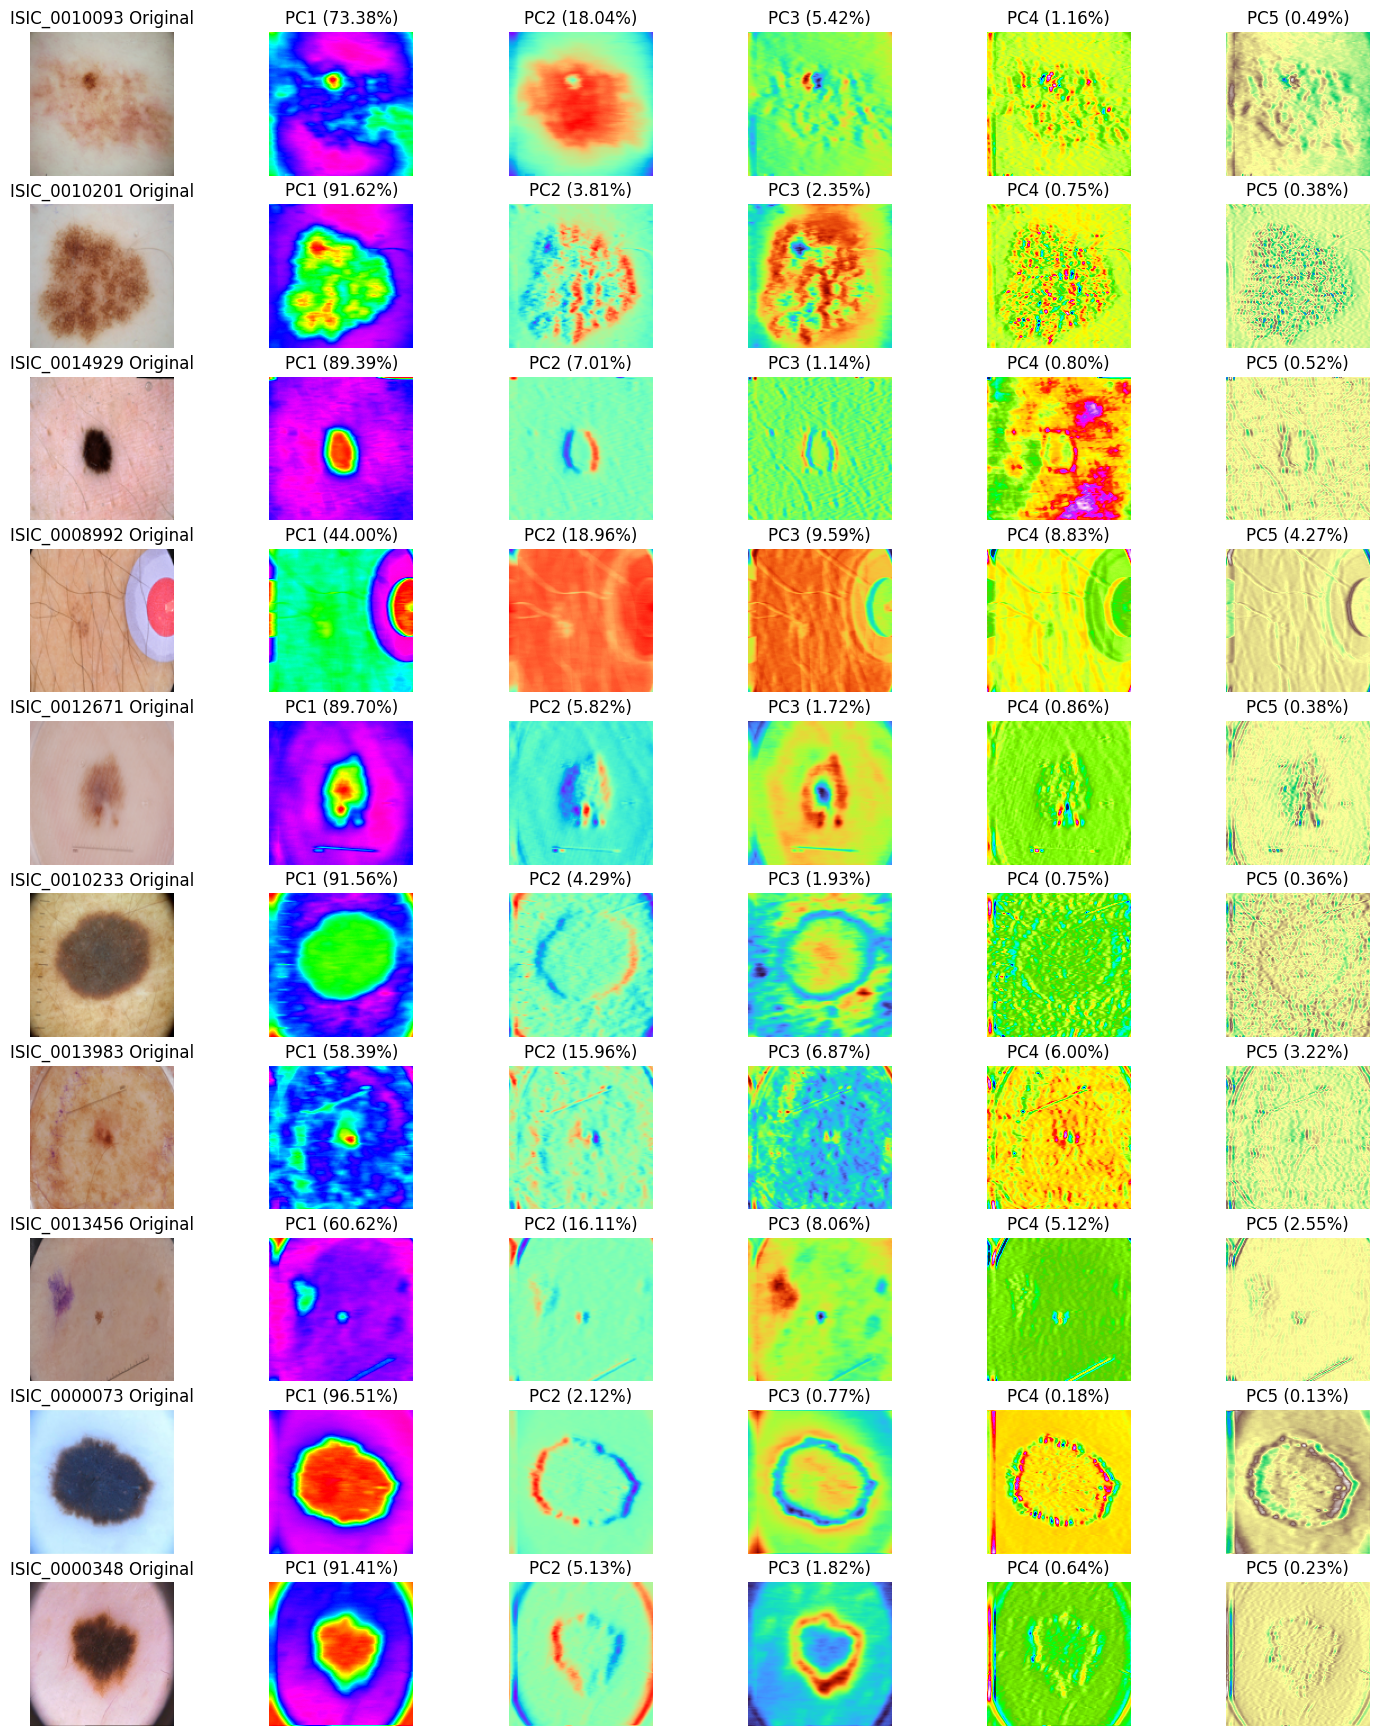

In [35]:
# plot the pca_np image
fig, ax = plt.subplots(10, 6, figsize=(18, 22))
colors = ['gist_rainbow', 'rainbow', 'turbo', 'gist_ncar', 'terrain']
for i, item in enumerate(images_dict.items()):
    if i == 10:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    for j, matrix in enumerate(item[1]['pca'][0]):
        ax[i, j+1].imshow(matrix, cmap=colors[j])
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'PC{j+1} ({item[1]['pca'][1][j]:.2f}%)')

In [ ]:
# function to calculate dice score given two numpy masks
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2. * intersection.sum() / (mask1.sum() + mask2.sum())

# function to calculate the IoU score given two numpy masks
def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return intersection.sum() / union.sum()

In [27]:
for i, item in enumerate(images_dict.items()):
    predictor.set_image(np.array(item[1]['image']))
    for j, matrix in enumerate(item[1]['pca'][0]):
            matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
            matrix_sam_fixed[0] = cv2.resize(matrix, (256, 256), interpolation=cv2.INTER_LINEAR)
            masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = masks[0]
            #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
            mask = np.array(mask).astype(np.float32)
            images_dict[item[0]][f'predicted_mask_pca{j}'] = mask

In [28]:
dict_results_points = {}
n_points_div2 = 10
for name, img in images.items():
    dict_results_points[name] = {}
    predictor.set_image(np.array(img))
    for i, (_, (matrices, _, _)) in enumerate(images_pca.items()):
        for j, matrix in enumerate(matrices):
            #mean_value = np.mean(matrix)
            #matrix[matrix < mean_value] = 0
            #matrix[matrix > mean_value] = 1
            # Flatten the matrix to work with probabilities
            flattened_matrix = matrix.flatten()
            # Normalize the pixel values to create probabilities
            probabilities_foreground = flattened_matrix / np.sum(flattened_matrix)
            # Get the indices of 10 randomly selected points, with higher probabilities for larger values
            selected_indices_foreground = np.random.choice(len(flattened_matrix), size=n_points_div2, replace=False, p=probabilities_foreground)
            # Convert the flattened indices back to 2D coordinates
            selected_points_foreground = np.array(np.unravel_index(selected_indices_foreground, matrix.shape)).T

            inverted_values = 1.0 - flattened_matrix
            probabilities_background = inverted_values / np.sum(inverted_values)
            selected_indices_background = np.random.choice(len(inverted_values), size=n_points_div2, replace=False, p=probabilities_background)
            selected_points_background = np.array(np.unravel_index(selected_indices_background, matrix.shape)).T

            selected_points = np.vstack((selected_points_foreground, selected_points_background))


            input_label = np.array([1] * n_points_div2 + [0] * n_points_div2) # foreground points + background points

            masks, scores, _ = predictor.predict(
                point_coords=selected_points,
                point_labels=input_label, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = masks[0]
            mask = np.array(mask).astype(np.float32)
            dict_results_points[name][f'mask_from_pca_{j+1}'] = mask

In [29]:
dict_results_clip = {}
for name, img in images.items():
    dict_results_clip[name] = {}
    predictor.set_image(np.array(img))
    for i, (_, (matrices, _, _)) in enumerate(images_pca.items()):
        for j, matrix in enumerate(matrices):
            mean_value = np.mean(matrix)
            matrix[matrix < mean_value] = 0
            matrix[matrix > mean_value] = 1
            matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
            matrix_sam_fixed[0] = cv2.resize(matrix, (256, 256), interpolation=cv2.INTER_LINEAR)
            masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = masks[0]
            #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
            mask = np.array(mask).astype(np.float32)
            dict_results_clip[name][f'mask_from_pca_{j+1}'] = mask

In [30]:
# plot for each image the mask for each pca component (input)
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i, (name, masks) in enumerate(dict_results.items()):
    ax[i, 0].imshow(images_pca[name][2])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(name + ' Original')
    for j, (component, mask) in enumerate(masks.items()):
        ax[i, j+1].imshow(mask, cmap='grey')
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{component}')

In [31]:
# plot for each image the mask for each pca component (input)
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i, (name, masks) in enumerate(dict_results_clip.items()):
    ax[i, 0].imshow(images_pca[name][2])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(name + ' Original')
    for j, (component, mask) in enumerate(masks.items()):
        ax[i, j+1].imshow(mask, cmap='grey')
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{component}')

In [32]:
# plot for each image the mask for each pca component (input)
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i, (name, masks) in enumerate(dict_results_points.items()):
    ax[i, 0].imshow(images_pca[name][2])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(name + ' Original')
    for j, (component, mask) in enumerate(masks.items()):
        ax[i, j+1].imshow(mask, cmap='grey')
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{component}')